# AI EU Project #

In [35]:
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_excel('pstw_dataset.xlsx')

## Drop unnused columns ##

In [36]:
# Ensures all the projects are within AI 
df = df[df['Primary Technology'].str.lower() == 'artificial intelligence']

# Replaces Pilot phase with pilot for consistensy
df[' Status'] = df[' Status'].replace({'Pilot phase': 'Pilot'})

# This will be the hyperparameter used when modelling
df_y = df[' Status']

# Resets the indexing so that it will match the other data when modelling
df_y = df_y.reset_index(drop=True)

# All columns needed for the project
columns = [
    "Geographical extent",
    "Functions of Government (COFOG level I)",
    "Functions of Government (COFOG level II)",
    "Process type",
    "Application type",
    "Cross Border",
    "Interaction",
    "Increase quality of PSI and services",
    "Improved management of public resources",
    "Increased quality of processes and systems",
    "AI Classification (I)",
    "AI Classification Subdomain (II) (main)",
    "AI Classification Subdomain (II) (Other I)",
    "AI Keywords",
    "Collaboration type",
    "Funding source"
]

# Columns to replace that contains X:s
x_columns = [
    # "Improved Public Service",
    # "Personalized Services",
    # "Public (citizen)-centered services",
    "Increase quality of PSI and services",
    # "More responsive, efficient, and cost-effective public services",
    # "New services or channels",
    # "Improved Administrative Efficiency",
    # "Cost-reduction",
    # "Responsiveness of government operation",
    "Improved management of public resources",
    "Increased quality of processes and systems",
    # "Open government capabilities",
    # "Increased transparency of public sector operations"
]

# Selects the right columns
df_selected = df[columns]

# Replaces X/ x with 1 or 0 to ease dummy-encoding
def translate_x(dataFrame, column):
  dataFrame[column] = dataFrame[column].replace({
      "x": 1,
      "X": 1,
      "\xa0": 0,
      np.nan: 0
  })
  dataFrame[column] = dataFrame[column].astype(int)

# Translates X in for the right columns
for column in x_columns:
    translate_x(df_selected, column)

# Dummy encoding
df_oh = pd.get_dummies(df_selected, dtype=int)

# Resets the index so that it will match when modelling
df_oh = df_oh.reset_index(drop=True)

print(df_oh.info())
print(df_y.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Columns: 262 entries, Increase quality of PSI and services to Funding source_Regional-funded project
dtypes: int64(262)
memory usage: 3.1 MB
None
['Not in use' 'Implemented' 'Pilot' 'Planned' 'In development']


/tmp/ipykernel_962183/2208283767.py:55: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataFrame[column] = dataFrame[column].replace({
/tmp/ipykernel_962183/2208283767.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame[column] = dataFrame[column].replace({
/tmp/ipykernel_962183/2208283767.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

Index(['Increase quality of PSI and services',
       'Improved management of public resources',
       'Increased quality of processes and systems',
       'Geographical extent_Across Countries',
       'Geographical extent_Across countries', 'Geographical extent_Local',
       'Geographical extent_National', 'Geographical extent_National ',
       'Geographical extent_Regional', 'Geographical extent_Regional ',
       ...
       'Collaboration type_Other PAs',
       'Collaboration type_Private corporation',
       'Collaboration type_Sandboxing', 'Collaboration type_Universities',
       'Collaboration type_Universities/Research organisations',
       'Funding source_EU-funded project',
       'Funding source_Funded with own resources',
       'Funding source_Local-funded project',
       'Funding source_National-funded project',
       'Funding source_Regional-funded project'],
      dtype='object', length=262)


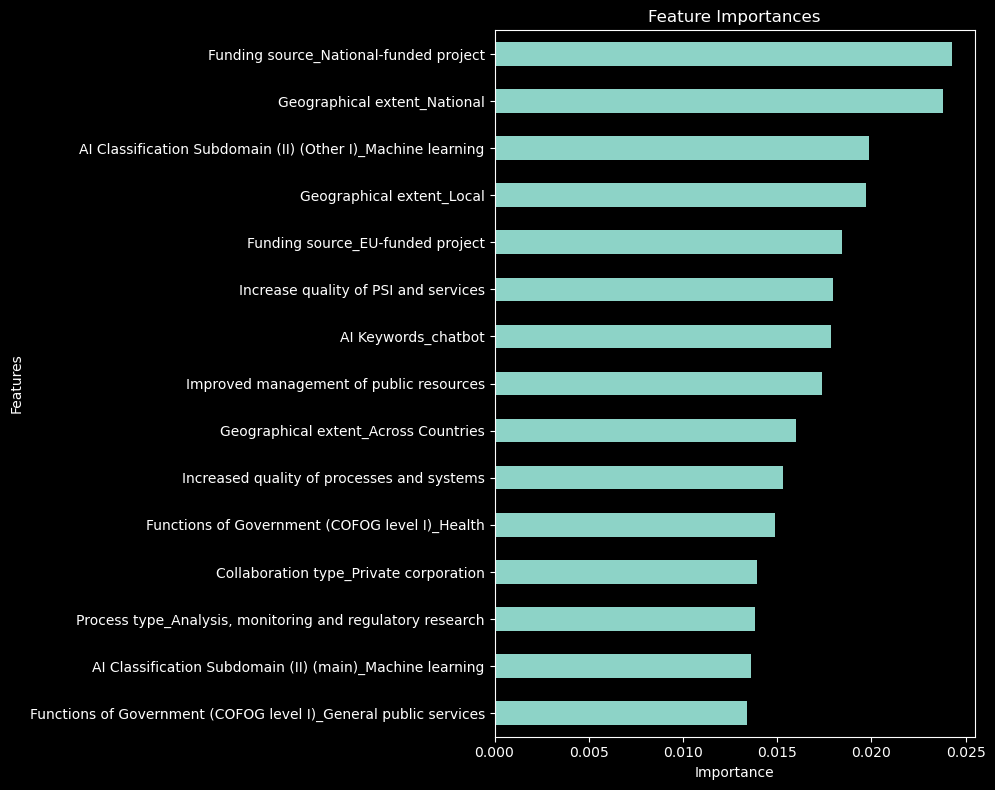

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Label encoding y-data
le = LabelEncoder()
y_encoded = le.fit_transform(df_y)

columns_x = [
    "Funding source_National-funded project",
    "Geographical extent_National",
    "AI Classification Subdomain (II) (Other I)_Machine learning",
    "Geographical extent_Local",
    "AI Keywords_chatbot",
    "Increased quality of processes and systems",
    "Improved management of public resources",
    "Increase quality of PSI and services",
    "Funding source_EU-funded project",
    "Collaboration type_Private corporation",
    "Geographical extent_Across Countries",
    "Functions of Government (COFOG level I)_Health",
    'Process type_Analysis, monitoring and regulatory research',
    "Geographical extent_Regional",
    "AI Classification Subdomain (II) (main)_Machine learning",
]

# Assigning data to variables
y = y_encoded
X = df_oh
X2 = df_oh[columns_x]

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=42, test_size=0.2)

# split data 2
X_train_val2, X_test2, y_train_val, y_test = train_test_split(X2, y, random_state=42, test_size=0.2)
X_train2, X_val2, y_train, y_val = train_test_split(X_train_val2, y_train_val, random_state=42, test_size=0.2)


# Scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)
X_train2 = scaler.fit_transform(X_train2)
X_val2 = scaler.fit_transform(X_val2)
X_test2 = scaler.fit_transform(X_test2)

rm_model = RandomForestClassifier()

rm_model.fit(X_train, y_train)

importances = rm_model.feature_importances_
feature_names = X.columns

print(feature_names)
feat_df = pd.DataFrame({
  'Feature': feature_names,
  'Importance': importances
})

filtered_df = feat_df[feat_df['Importance'] > 0.013]

filtered_df = filtered_df.sort_values(by='Importance', ascending=True)

# print(importances)

filtered_df.plot(
    kind='barh',
    x='Feature',
    y='Importance',
    legend=False,
    figsize=(10, 8)
)

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

plt.tight_layout()
plt.show()

plt.show() 

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

svc = SVC()
rm_cl = RandomForestClassifier(random_state=42)
# log_reg = LogisticRegression(random_state=42, max_iter=5000)
et_cl = ExtraTreesClassifier(random_state=42)

hypergrid_svc = {
  'kernel': ['rbf', 'poly', 'sigmoid'],
  'C': [0.1, 1, 10],
  'gamma': [0.01, 0.1, 0.5, 1],
  'decision_function_shape': ['ovo', 'ovr']
}

hypergrid_rm = {
  'n_estimators': [10, 50, 100, 150],
  'min_samples_split': [2, 5, 10]
}

# hypergrid_log = [
#   {
#     'penalty': ['l2'],
#     'C': [0.1, 1, 10],
#     'solver': ['saga', 'lbfgs', 'newton-cg']
#   },
#   {
#     'penalty': ['l1'],
#     'C': [0.1, 1, 10],
#     'solver': ['saga']
#   },
#   {
#     'penalty': ['elasticnet'],
#     'C': [0.1, 1, 10],
#     'solver': ['saga'],
#     'l1_ratio': [0.1, 0.5, 0.9]
#   }
# ]

svc_model_gs = GridSearchCV(svc, hypergrid_svc, scoring='accuracy', cv=5)
rm_model_gs = GridSearchCV(rm_cl, hypergrid_rm, scoring='accuracy', cv=5)
et_model_gs = GridSearchCV(et_cl, hypergrid_rm, scoring='accuracy', cv=5)

svc_model_gs2 = GridSearchCV(svc, hypergrid_svc, scoring='accuracy', cv=5)
rm_model_gs2 = GridSearchCV(rm_cl, hypergrid_rm, scoring='accuracy', cv=5)
et_model_gs2 = GridSearchCV(et_cl, hypergrid_rm, scoring='accuracy', cv=5)
# log_model_gs = GridSearchCV(log_reg, hypergrid_log, scoring='accuracy')

svc_model_gs.fit(X_train, y_train)
rm_model_gs.fit(X_train, y_train)
et_model_gs.fit(X_train, y_train)
# log_model_gs.fit(X_train, y_train)
svc_model_gs2.fit(X_train2, y_train)
rm_model_gs2.fit(X_train2, y_train)
et_model_gs2.fit(X_train2, y_train)

print(f"Best params for SVC:", svc_model_gs.best_params_)
print(f"Best params for RM:", rm_model_gs.best_params_)
print(f"Best params for ET:", et_model_gs.best_params_)
# print(f"Best params for LOG:", log_model_gs.best_params_)


Best params for SVC: {'C': 1, 'decision_function_shape': 'ovo', 'gamma': 0.01, 'kernel': 'poly'}
Best params for RM: {'min_samples_split': 5, 'n_estimators': 50}
Best params for ET: {'min_samples_split': 5, 'n_estimators': 50}


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

voting_clf = VotingClassifier(
  estimators=[('svc', svc_model_gs), 
              ('rm_cl', rm_model_gs), 
              ('et_cl', et_model_gs)]
)

for clf in (svc_model_gs, rm_model_gs, et_model_gs):
  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)
  print(clf.best_estimator_, 'Accuracy score:', accuracy_score(y_test, y_pred))
  print(clf.best_estimator_, 'Precision score:', precision_score(y_test, y_pred, average='macro'))
  print(clf.best_estimator_, 'Recall score:', recall_score(y_test, y_pred, average='macro'))
  print(clf.best_estimator_, 'F1 score:', f1_score(y_test, y_pred, average='macro'))

for clf in (svc_model_gs2, rm_model_gs2, et_model_gs2):
  clf.fit(X_train2, y_train)

  y_pred = clf.predict(X_test2)
  print(clf.best_estimator_, 'Accuracy score:', accuracy_score(y_test, y_pred))
  print(clf.best_estimator_, 'Precision score:', precision_score(y_test, y_pred, average='macro'))
  print(clf.best_estimator_, 'Recall score:', recall_score(y_test, y_pred, average='macro'))
  print(clf.best_estimator_, 'F1 score:', f1_score(y_test, y_pred, average='macro'))


SVC(C=1, decision_function_shape='ovo', gamma=0.01, kernel='poly') Accuracy score: 0.5873015873015873
SVC(C=1, decision_function_shape='ovo', gamma=0.01, kernel='poly') Precision score: 0.32923381908254523
SVC(C=1, decision_function_shape='ovo', gamma=0.01, kernel='poly') Recall score: 0.3407781460107041
SVC(C=1, decision_function_shape='ovo', gamma=0.01, kernel='poly') F1 score: 0.32966519781588277
RandomForestClassifier(min_samples_split=5, n_estimators=50, random_state=42) Accuracy score: 0.6285714285714286
RandomForestClassifier(min_samples_split=5, n_estimators=50, random_state=42) Precision score: 0.3701652963343611
RandomForestClassifier(min_samples_split=5, n_estimators=50, random_state=42) Recall score: 0.4044154619736015
RandomForestClassifier(min_samples_split=5, n_estimators=50, random_state=42) F1 score: 0.38636406574721327
ExtraTreesClassifier(min_samples_split=5, n_estimators=50, random_state=42) Accuracy score: 0.6
ExtraTreesClassifier(min_samples_split=5, n_estimators=

In [ ]:
svc_pred = svc_model_gs.predict(X_val)
rm_pred = rm_model_gs.predict(X_val)
et_pred = et_model_gs.predict(X_val)
# log_pred = log_model_gs.predict(X_val)

ac_svc = accuracy_score(y_val, svc_pred)
ac_rm = accuracy_score(y_val, rm_pred)
ac_et = accuracy_score(y_val, et_pred)
# ac_log = accuracy_score(y_val, log_pred)

print(f"Test Accuracy SVC: {ac_svc:.2f}")
print(f"Test Accuracy RM: {ac_rm:.2f}")
print(f"Test Accuracy ET: {ac_et:.2f}")
# print(f"Test Accuracy LOG: {ac_log:.2f}")

Test Accuracy SVC: 0.53
Test Accuracy RM: 0.53
Test Accuracy ET: 0.53


In [ ]:
voting_clf = VotingClassifier(
  estimators=[('svc', svc), 
              ('rm_cl', rm_cl), 
              ('et_cl', et_cl), 
              ('log_reg', log_reg)]
)

for clf in (svc, rm_cl, et_cl, log_reg, voting_clf):
  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

SVC 0.5841269841269842
RandomForestClassifier 0.6
ExtraTreesClassifier 0.5873015873015873
LogisticRegression 0.5015873015873016
VotingClassifier 0.6063492063492063
